This ipython notebook demonstrates how to calculate photometric (optimal psf-weighted) SNR for sources observed with LSST. 

It uses the LSST [throughputs](https://github.com/lsst/throughputs) curves, together with the LSST [rubin_sim](https://github.com/lsst/rubin_sim) package, to calculate the SNR for any spectrum. 

With an eye toward turning this into a more generalized SNR calculator, an overview of the process (starting from the spectrum) is:
* Set the desired magnitude (in a standardized throughput curve) for the source.
* Generate the throughput curves in all filters, for the airmass desired.
* Set the sky SED (for now we just use dark, zenith sky).
* Calculate the SNR. 

---

This notebook assumes that the `rubin_sim` package has been installed and setup, and that throughput and sed files have been downloaded to `RUBIN_SIM_DATA_DIR`. We can then import the necessary packages:

In [1]:
from __future__ import print_function
import os
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from rubin_sim.photUtils import Bandpass
from rubin_sim.photUtils import Sed
from rubin_sim.photUtils import SignalToNoise
from rubin_sim.photUtils import PhotometricParameters

---
<b>Read in the spectra.</b> 

I put together a few SEDs that cover a fairly wide range: elliptical and spiral galaxies, blue and red stars, and a quasar. We'll read them all into `Sed` objects, and set the quasar to have a redshift of 3.5. These SEDS are available are present in the directory rubin_sim_notebooks/seds.

In [2]:
sedDir = '../seds'
filenames = glob.glob(os.path.join(sedDir,'*'))
print(filenames)

['../seds/Ell2_template_norm.sed.dat', '../seds/km10_4500.fits_g45', '../seds/km10_5250.fits_g45', '../seds/km10_6000.fits_g45', '../seds/km10_6500.fits_g45', '../seds/km10_7250.fits_g45', '../seds/m3.0Full.dat', '../seds/quasar.dat', '../seds/Sa_template_norm.sed.dat', '../seds/Sdm_template_norm.sed0.dat']


In [3]:
# Now we'll read in each of those individual seds, into a Sed object. 
seds = {}
for s in filenames:
    skey = os.path.basename(s)
    seds[skey] = Sed()
    seds[skey].readSED_flambda(s)

# We'll also redshift the quasar.
z = 3.5
if 'quasar.dat' in seds:
    seds['quasar.dat'].redshiftSED(z)    

---
<b>Read the standard throughput curves</b>.

First, get the names of the directories containing the baseline throughput curves and a set of standard atmosphere curves at a range of airmass (also from the throughputs package). We'll also take a peek at the contents of these directories, in case you haven't seen them before.

In [4]:
fdir = os.getenv('RUBIN_SIM_DATA_DIR')
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

throughputsDir = os.path.join(fdir, 'throughputs', 'baseline')

!ls $throughputsDir

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'y', 'z':'r', 'y':'m'}

atmos_10.dat   filter_u.dat    hardware_y.dat  m3.dat		 total_y.dat
atmos_std.dat  filter_y.dat    hardware_z.dat  README.md	 total_z.dat
darksky.dat    filter_z.dat    lens1.dat       README_SOURCE.md  version_info
detector.dat   hardware_g.dat  lens2.dat       total_g.dat
filter_g.dat   hardware_i.dat  lens3.dat       total_i.dat
filter_i.dat   hardware_r.dat  m1.dat	       total_r.dat
filter_r.dat   hardware_u.dat  m2.dat	       total_u.dat


Read in the set of throughput curves we'll use as our "standard". These are the 'standard' LSST total throughput curves and use an X=1.2 atmosphere (with aerosols) together with the standard hardware components (with time-average losses). 

In [5]:
lsst_std = {}
for f in filterlist:
    lsst_std[f] = Bandpass()
    lsst_std[f].readThroughput(os.path.join(throughputsDir, 'total_'+f+'.dat'))

---
<b>Set the desired magnitude.</b>

Use these standard throughput curves to set the desired magnitude for each SED in the desired reference bandpass. This is the step where the user decides the magnitude of the source they want to use to calculate SNR.

In [6]:
stdFilter = 'r'
stdMag = 24.0
for s in seds:
    fluxNorm = seds[s].calcFluxNorm(stdMag, lsst_std[stdFilter])
    seds[s].multiplyFluxNorm(fluxNorm)

Pretty plot #1: plot the SEDs.

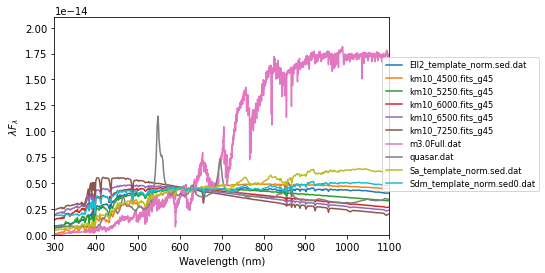

In [7]:
for s in seds:
    plt.plot(seds[s].wavelen, seds[s].flambda*seds[s].wavelen, label='%s' %(s))
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.xlim(300, 1100)
plt.ylim(0.,2.1e-14)
plt.legend(loc=(0.98, 0.2), fontsize='smaller', numpoints=1, fancybox=True)

---
<b>Read in the (non-standard) throughput components</b>

Read in the various components that we will need, in order to generate the non-standard throughput curves at arbitrary airmass. 
First, the system hardware throughput components, as we will need the hardware alone to calculate SNR anyway. (see [note (1)](#hardware_sky) below for more information). 

In [8]:
lsst_system = {}
for f in filterlist:
    lsst_system[f] = Bandpass()
    lsst_system[f].readThroughputList(['detector.dat', 'lens1.dat', 'lens2.dat', 'lens3.dat', 
                                       'm1.dat', 'm2.dat', 'm3.dat', 'filter_'+f+'.dat'], 
                                        rootDir=throughputsDir)

Then read in the atmosphere, so we can multiply it into the system hardware throughputs. This lets us generate the total throughput curves, using a wider variety of atmosphere curves at varying airmass. (The standard total throughput curves use X=1.2, for now we'll use X=1.0 here).


In [9]:
atmosphere = Bandpass()
X = 1.0

# this is the v1.5 file, with aerosols
#atmosDir = os.path.join(fdir, 'throughputs', 'baseline')
#atmosphere.readThroughput(os.path.join(atmosDir, 'atmos_%d.dat' %(X*10)))

# this is the v1.0 file, no aeorosols
atmosDir = os.path.join(fdir, 'throughputs', 'atmos')
atmosphere.readThroughput(os.path.join(atmosDir, 'atmos_%d.dat' %(X*10)))

Calculate the total (non-standard) throughput curves, including the atmosphere. 

In [10]:
lsst_total = {}
for f in filterlist:
    wavelen, sb = lsst_system[f].multiplyThroughputs(atmosphere.wavelen, atmosphere.sb)
    lsst_total[f] = Bandpass(wavelen=wavelen, sb=sb)

Pretty plot #2, plot the throughput curves + atmosphere.  The dotted lines are the hardware-only throughputs, the solid lines are total system throughputs including atmosphere.

Text(0.5, 1.0, 'System throughput New')

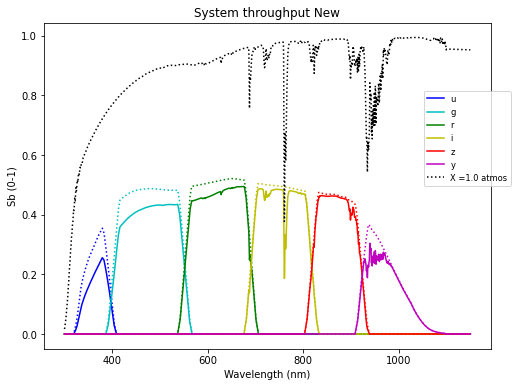

In [11]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(lsst_total[f].wavelen, lsst_total[f].sb,  linestyle='-', color=filtercolors[f], label='%s' %(f))
    plt.plot(lsst_system[f].wavelen, lsst_system[f].sb, linestyle=':', color=filtercolors[f])
plt.plot(atmosphere.wavelen, atmosphere.sb, 'k:', label='X =%.1f atmos' %(X))
#plt.plot(atmosphere.wavelen, atmosphere.sb, 'k:', label='std atmos' )
#plt.xlim(300,1100)
plt.legend(loc=(0.85, 0.5), fontsize='smaller', fancybox=True, numpoints=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sb (0-1)')
plt.title('System throughput New')

---
<b>Calculate SNR</b>

The SNR of a source depends on the sky background, as well as properties of the telescope and camera. We can use the default values for LSST telescope and camera properties automatically. At the moment, the only sky spectrum we have easily available is the dark sky zenith spectrum, from the [$LSST_THROUGHPUTS_BASELINE/darksky.dat](https://github.com/lsst/throughputs/blob/master/baseline/darksky.dat) file. This spectra is calibrated to have the appropriate magnitudes in the LSST bandpasses under dark sky, zenith conditions.

TODO: update source of this darksky.dat

In [12]:
darksky = Sed()
darksky.readSED_flambda(os.path.join(throughputsDir, 'darksky.dat'))

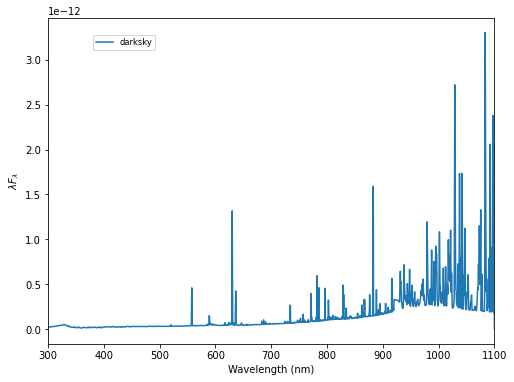

In [13]:
plt.figure(figsize=(8,6))
plt.plot(darksky.wavelen,darksky.flambda*darksky.wavelen,label='darksky')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.xlim(300, 1100)
plt.legend(loc=(0.1, 0.9), fontsize='smaller', numpoints=1, fancybox=True)

Calculate the SNR, assuming optimal measurement over the PSF. This means we can choose the PSF as well.<br>
`Sed` method `calcSNR_psf` accepts an instantiation of the `PhotometricParameters` class, which carries values for readnoise, platescale, gain, number of exposures, etc, set to defaults appropriate for general LSST purposes (and assuming 30 second visits, consisting of two 15 second exposures). 

In [14]:
# Set up the photometric parameters for LSST
photParams = PhotometricParameters(gain=1)
# Set up the seeing. "seeing" traditional = FWHMgeom in our terms 
#  (i.e. the physical size of a double-gaussian or von Karman PSF)
# But we use the equivalent FWHM of a single gaussian in the SNR calculation, so convert.
seeing = 0.7
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)

In [15]:
print(photParams.bandpass)
print(photParams.exptime)
print(photParams.effarea)
print(photParams.gain)   
print(photParams.platescale)
print(photParams.sigmaSys)  #these are errors in photometry - 0.005 in g,r,i so an error of 0.07 mag
print(photParams.readnoise) #8.8e- is also on the high side for most CCDs, but ok...
print(photParams.darkcurrent) # set to an upper bound here, typical values are x10 smaller
print(photParams.othernoise)
print(photParams.nexp)

None
15.0
324015.4546769212
1
0.2
0.005
8.8
0.2
0.0
2


In [16]:
# We can investigate the SNR calculation a little closer for a single object, let's use the Mdwarf.
s = 'm3.0Full.dat'
f = 'r'
print("SNR in %s band" % f)
_ = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams, FWHMeff, verbose=True)
print('')
f = 'z'
print("SNR in %s band" % f)
_ = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams, FWHMeff, verbose=True)

SNR in r band
For Nexp 2.0 of time 15.0: 
Counts from source: 1409.41  Counts from sky: 809.73
FWHMeff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 28.46 Noise from instrument: 12.68
Noise from source: 37.54
 Total Signal: 1409.41   Total Noise: 188.63    SNR: 7.47

SNR in z band
For Nexp 2.0 of time 15.0: 
Counts from source: 3652.37  Counts from sky: 1713.37
FWHMeff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 41.39 Noise from instrument: 12.68
Noise from source: 60.43
 Total Signal: 3652.37   Total Noise: 263.89    SNR: 13.84


In [17]:
# why is total noise 189 for the r band above? 

# ah - Noise from sky & instrument are probably per pixel, and need to be added for Neff pixels...
# add is Counts from sky also per pixel?

# so noise from sky = 28.46 per pixel, 35.2 pixels so sky_noise = 28.5 * sqrt(35.2) = 169
# then with noise from instrument = 12.7 per pixel inst_noise = 12.7 * sqrt(35.2) = 75.3
# combine those with noise from source of 37.5, gives 189 - ok!

# also it seems that you cannot call photParams and/or calcSNR_sed multiple times and get reasonable results

In [18]:
photParams_no = PhotometricParameters(gain=1)

s = 'm3.0Full.dat'
f = 'r'
print("SNR in %s band" % f)
_ = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams_no, FWHMeff, verbose=True)

SNR in r band
For Nexp 2.0 of time 15.0: 
Counts from source: 1409.41  Counts from sky: 809.73
FWHMeff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 28.46 Noise from instrument: 12.68
Noise from source: 37.54
 Total Signal: 1409.41   Total Noise: 188.63    SNR: 7.47


In [19]:
# Calculate SNR for all seds in all filters.
snr = pd.DataFrame(index=seds, columns=filterlist)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                                   photParams, FWHMeff=FWHMeff, verbose=False)
pd.set_option('precision', 3)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,1.027,7.615,7.483,5.807,3.792,1.829
km10_4500.fits_g45,0.419,5.588,7.48,6.437,4.221,1.987
km10_5250.fits_g45,1.009,7.289,7.483,5.752,3.503,1.557
km10_6000.fits_g45,1.707,8.686,7.484,5.324,3.079,1.313
km10_6500.fits_g45,2.054,9.546,7.485,5.081,2.851,1.193
km10_7250.fits_g45,2.375,10.764,7.487,4.749,2.549,1.051
m3.0Full.dat,0.203,3.499,7.472,14.496,13.841,7.208
quasar.dat,0.538,6.287,7.488,5.479,3.338,1.365
Sa_template_norm.sed.dat,0.611,6.133,7.481,6.599,4.903,2.585
Sdm_template_norm.sed0.dat,1.562,8.296,7.483,5.935,4.117,2.095


Note that the SNR in the r band is the same for all of these objects. This makes sense, as we normalized them all to have the same r band standard magnitudes, and the X=1.0 atmosphere is not hugely different from the X=1.2 standard throughput curves.  However, their SNR in other bandpasses can be quite different depending on the SED of the source. 

---
And it's a bit of a hack, but we could make the same calculation for different sky background values, by scaling the dark sky SED to have different expected magnitudes (i.e. adjust the darksky SED to create different sky brightness). With the upcoming sky brightness code (in progress [here](http://github.com/lsst/sims_skybrightness)), we could use the actual sky SED for any conditions.

<a name='hardware_sky'>(1)</a> Notice that I use lsst_system throughputs here, not lsst_total. This is because the sky magnitudes must be calculated using the *system* only, not including the atmosphere. The sky brightness is generated at various points throughout the atmosphere, so should not be propagated through the entire atmosphere when calculating the transmission to the focal plane (unlike sources above the atmosphere). Without doing proper radiative transfer to determine the atmosphere and sky brightness to use, the next best thing is to just use the system minus the atmosphere, and atmosphere-corrected/telescope pupil skybrightness measurements (which are what are usually reported). This is also why we needed to pass the system only throughput curves to calcSNR_sed. 

In [20]:
for f in filterlist:
    print(f, darksky.calcMag(lsst_system[f]))

u 22.988640526139378
g 22.256460844980268
r 21.19621923005915
i 20.477858428533015
z 19.599676728581212
y 18.61181054145898


In [21]:
newSkyMag = 20.5
newSkyFilter = 'r'
fluxNorm = darksky.calcFluxNorm(newSkyMag, lsst_system[newSkyFilter])
darksky.multiplyFluxNorm(fluxNorm)
for f in filterlist:
    print(f, darksky.calcMag(lsst_system[f]))

u 22.292421296080228
g 21.560241614921118
r 20.5
i 19.781639198473865
z 18.903457498522062
y 17.91559131139983


In [22]:
# Calculate SNR with varied sky brightness
photParams = PhotometricParameters()
seeing = 0.7
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)
snr = pd.DataFrame(index=seds, columns=filterlist)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, FWHMeff=FWHMeff, verbose=False)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.912,6.005,5.706,4.368,2.819,1.35
km10_4500.fits_g45,0.372,4.394,5.704,4.846,3.139,1.467
km10_5250.fits_g45,0.897,5.745,5.705,4.327,2.604,1.149
km10_6000.fits_g45,1.517,6.858,5.707,4.003,2.288,0.969
km10_6500.fits_g45,1.827,7.546,5.707,3.82,2.118,0.881
km10_7250.fits_g45,2.113,8.523,5.708,3.569,1.893,0.775
m3.0Full.dat,0.18,2.743,5.697,11.0,10.378,5.344
quasar.dat,0.478,4.948,5.709,4.12,2.48,1.008
Sa_template_norm.sed.dat,0.542,4.826,5.704,4.969,3.648,1.91
Sdm_template_norm.sed0.dat,1.389,6.548,5.706,4.466,3.061,1.547


In [23]:
# Vary the seeing (with this new sky background)
photParams = PhotometricParameters()
seeing = 1.2
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, FWHMeff=FWHMeff, verbose=False)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.516,3.428,3.246,2.479,1.595,0.763
km10_4500.fits_g45,0.21,2.501,3.245,2.751,1.777,0.829
km10_5250.fits_g45,0.508,3.278,3.246,2.455,1.473,0.649
km10_6000.fits_g45,0.861,3.921,3.247,2.27,1.294,0.548
km10_6500.fits_g45,1.038,4.32,3.247,2.166,1.198,0.498
km10_7250.fits_g45,1.201,4.888,3.248,2.023,1.07,0.438
m3.0Full.dat,0.102,1.557,3.241,6.29,5.918,3.03
quasar.dat,0.27,2.819,3.248,2.337,1.403,0.569
Sa_template_norm.sed.dat,0.307,2.749,3.245,2.821,2.067,1.08
Sdm_template_norm.sed0.dat,0.788,3.742,3.246,2.534,1.733,0.875


In [24]:
# Or vary the readnoise (for example) -- notice biggest effect in u band
old_readnoise = photParams.readnoise
print(old_readnoise)
photParams = PhotometricParameters(readnoise=old_readnoise*2)
seeing = 1.2
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, FWHMeff=FWHMeff, verbose=False)
display(snr)

8.8


,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.321,2.802,2.879,2.264,1.497,0.726
km10_4500.fits_g45,0.131,2.043,2.878,2.513,1.668,0.789
km10_5250.fits_g45,0.316,2.679,2.879,2.243,1.383,0.618
km10_6000.fits_g45,0.536,3.206,2.879,2.074,1.214,0.521
km10_6500.fits_g45,0.646,3.533,2.88,1.978,1.124,0.474
km10_7250.fits_g45,0.748,3.999,2.88,1.848,1.004,0.417
m3.0Full.dat,0.063,1.271,2.874,5.75,5.555,2.885
quasar.dat,0.168,2.304,2.881,2.135,1.317,0.542
Sa_template_norm.sed.dat,0.191,2.246,2.878,2.577,1.939,1.028
Sdm_template_norm.sed0.dat,0.49,3.059,2.879,2.315,1.626,0.833
